In [2]:
import numpy as np 
from scipy import fftpack as ft
from scipy import stats 
import scipy as sp
from copy import deepcopy as dp 
from scipy.fftpack import idct,dct
import scipy.io as sio
from numpy import linalg as LA
import matplotlib.pyplot as plt  
import pyStarlet as ps
import initialization as pyl
import Utils_generation as utils  
import generation_rodriguez as gen
import algoS as algS
import threshold_strategy as thres
import FISTA as algoA

import stopping_criterion

In [3]:

Lower_freq=80
Higher_freq=100

#sources generated from a Bernoulli-Gaussian distribution of activation parameter 0.1 and convolved with 
#Laplacian of width w=5
Se=sio.loadmat('sources')['Se']
ru=1
rho=.5
Energy=1.5
nb_sces=2
nb_obs=5
nb_pix=1500
Angle_btwn=np.pi/3

SNR=65


In [4]:

ru=1
while ru>0:
    (A2, e1,e2,VS1u, VS2u, ru1, ru2)=gen.generate_A_ndim(Higher_freq,rho, Angle_btwn, Energy, nb_pix, lower_freq=Lower_freq,n=nb_sces, m=nb_obs)
    ru=np.sum(A2<0)


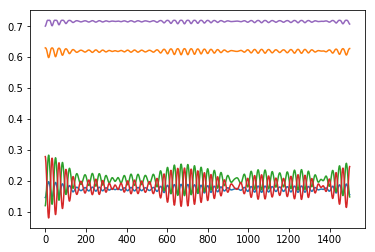

In [5]:
plt.plot(A2[:,:,0].T)

In [6]:
(X, N, sigma_noise)=utils.XN(A2, Se, m=nb_obs, t=nb_pix, noise_level=SNR)

#Initialization:
dS={}
dS['n']=nb_sces
dS['m']=nb_obs
dS['t']=nb_pix
dS['kSMax']=1
dS['iteMaxXMCA']=5000
dPatch={}
dPatch['PatchSize']=500
dPatch['aMCA']=0
dPatch['J']=1
Aout, Sout, Ar, Sr,temp2 ,ss= pyl.GMCAperpatch(X, dS, dPatch, Init=1, aMCA=0)

for r in range(nb_sces):
    Aout[:,:,r] = pyl.Filter1D(x=Aout[:,:,r].squeeze(),J=np.int(np.log2(1536)+1)-1)
    

([<matplotlib.lines.Line2D at 0x102913610>,
  <matplotlib.lines.Line2D at 0x1029380d0>])

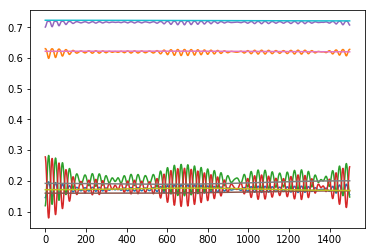

In [7]:
plt.plot(A2[:,:,0].T), plt.plot(Aout[:,:,0].T)

In [8]:
A0=np.zeros(( 5,nb_pix ,2))
A0=dp(Aout)
Afre=gen.moyFrechet(Aout)
for l in range(nb_pix):
   A0[:,l,:]=Afre 

#Decreasing threshold starting from a percentile of the detected variabilities
seuil_1=thres.threshold_finalstep(3,sigma_noise,10./100.,Sout, Aout, A0, X, 5,  1)

(A_1, r,ecartre,elapsed_time)= algoA.FISTA(Sout, X, A0, Aout,seuil_1, 8000,lim=5e-7 ,stepg=.8, iteprox=6000, limprox=1e-6)

1500
1500
('threshold based on the nbr of coefs', 0, 2)
('threshold based on the nbr of coefs', 0, 2)


In [9]:
    A=np.zeros((400, 5,nb_pix ,2))
    S=np.zeros((400, 2, nb_pix ))
    seuil=np.zeros((400, nb_pix, 2))
    
    
    S[0,:,:]=dp(Sout)
    A[0,:,:,:]=dp(A_1)
    #%
    
    inner_ecart=[]
    
    outer_ecart=[]
    
    outer_time=[]
    #%
    
    
    l=dp(0)
    
    for k in np.arange(l, l+399):    
       print(k)
     
       S[k+1,:,: ]=algS.lasso_star(X, A[k,:,:,:], S[k,:,:],kend=3, stepgg=1.,resol=2, lim=1e-6)
    
       Afre=gen.moyFrechet(A[k,:,:,:])
       for l in range(nb_pix):
           A0[:,l,:]=Afre 
    #   
       seuil[k+1,:,:] = thres.threshold_finalstep(3,sigma_noise,(10.+5.*k)/100.,S[k+1,:,:], A[k,:,:,:], A0, X, 5,  1)
       (A[k+1,:,:,:],r,ecartre,elapsed_time)= algoA.FISTA(S[k+1,:,:], X, A0, A[k,:,:,:],seuil[k+1,:,:], 6000,lim=1e-6 ,stepg=.8, iteprox=6000, limprox=4e-6)
       
       
       inner_ecart.append(ecartre)
       
       if ecartre[-1]>5e-5:
           break
       
       outer_time.append(elapsed_time)
        
       eA=stopping_criterion.spectral_var_rel(A[k+1,:,:,:], A[k,:,:,:])
    
       if eA<1e-6:
           break
       
       outer_ecart.append(eA)

0
0.0344075012887
0.00594251210968
0.0046627019824
0.00323670467252
0.00188312924065
0.000842457340933
0.000202416179881
0.000195002399771
0.000273165502603
0.000226114431782
0.000125435834377
3.47104382951e-05
2.7396746246e-05
4.54249479664e-05
3.93285327764e-05
2.27654703449e-05
6.67675483323e-06
5.9358784706e-06
9.8483509939e-06
8.91270931107e-06
5.17421929257e-06
1.36844838652e-06
1.47683060281e-06
2.33853378391e-06
2.02172205997e-06
1.15842746054e-06
3.0452264416e-07
1498
1497
('threshold based on the nbr of coefs', 0, 2)
('threshold based on the nbr of coefs', 0, 2)
1
0.000604513917212
0.000280683069201
0.000230693153873
0.000161652671733
9.47979448414e-05
4.23062796527e-05
8.75626156025e-06
8.89754192957e-06
1.32001668162e-05
1.07139198531e-05
5.83773545404e-06
1.45159899946e-06
1.31184390766e-06
2.22911327644e-06
1.93692851769e-06
1.10672555726e-06
2.85804927914e-07
1499
1496
('threshold based on the nbr of coefs', 0, 2)
('threshold based on the nbr of coefs', 0, 2)
2
0.0004812

([<matplotlib.lines.Line2D at 0x10b024fd0>,
  <matplotlib.lines.Line2D at 0x10b04ead0>])

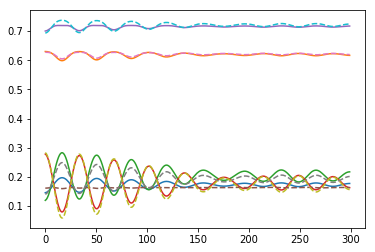

In [11]:
plt.plot(A2[:,:300,0].T), plt.plot(A[k,:,:300,0].T, '--')